In [3]:
import pandas as pd
import numpy as np
import math
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy import stats
import networkx as nx

%matplotlib inline

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
train_df = pd.read_csv('../data/drugcell_all.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
drugs = pd.read_csv('../data/drug2ind.txt', sep='\t', header=None, names=['I', 'D'])['D']
cell_mutation = np.loadtxt('../data/Reactome/cell2mutation.txt', delimiter=',')
ontology = pd.read_csv('../data/Reactome/Reactome_small_ont.txt', sep='\t', header=None, names=['S', 'T', 'I'])

genes = set(pd.read_csv('../data/Reactome/gene2ind.txt', sep='\t', header=None, names=['I', 'G'])['G'])
genes_orig = set(pd.read_csv('../../drugcell/data/gene2ind.txt', sep='\t', header=None, names=['I', 'G'])['G'])

cells = set(pd.read_csv('../data/cell2ind.txt', sep='\t', header=None, names=['I', 'C'])['C'])
cells_orig = set(pd.read_csv('../../drugcell/data/cell2ind.txt', sep='\t', header=None, names=['I', 'C'])['C'])

In [6]:
# No. of mutations in cell-lines

mutation_count = np.count_nonzero(cell_mutation == 1, axis=1)

In [7]:
np.median(mutation_count)

124.0

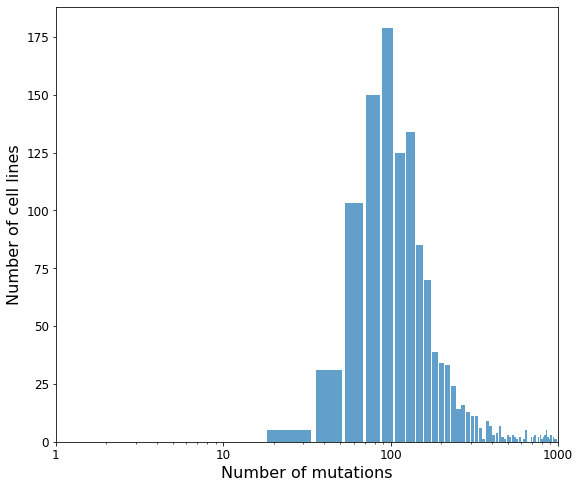

In [8]:
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111)
ax.hist(x=mutation_count, bins='auto', alpha=0.7, rwidth=0.85)
ax.grid(False)
ax.set_xlabel('Number of mutations')
ax.set_ylabel('Number of cell lines')
ax.set_xscale("log")
ax.set_xlim(1, 1000)
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.show()
fig.savefig('../plots/Reactome_small_mutation_count.png')

In [9]:
def load_ontology(file_name):
    dG = nx.DiGraph()
    file_handle = open(file_name)
    for line in file_handle:
        line = line.rstrip().split()
        if line[2] == 'default':
            dG.add_edge(line[0], line[1])
    file_handle.close()    
    return dG
#dg = load_ontology('../../drugcell/data/drugcell_ont.txt')
dg = load_ontology('../data/Reactome/Reactome_small_ont.txt')

In [10]:
def get_next_layer(dg, stack, term_visited):
    new_stack = []
    count = 0
    while len(stack) > 0:
        term = stack.pop()
        count += 1
        if term in term_visited:
            continue
        term_visited[term] = 1
        for n in list(dg.neighbors(term)):
            new_stack.append(n)
    return new_stack, count
            

root = [n for n in dg.nodes() if dg.in_degree(n) == 0][0]
next_layer = list(dg.neighbors(root))
term_visited = {}
layers = []
i = 0
layers.append(1)
term_visited[root] = 1
while len(next_layer) > 0:
    i += 1
    layers.append(0)
    next_layer, layers[i] = get_next_layer(dg, next_layer, term_visited)

layers.reverse()

In [11]:
layers

[2, 8, 15, 27, 45, 30, 48, 1]

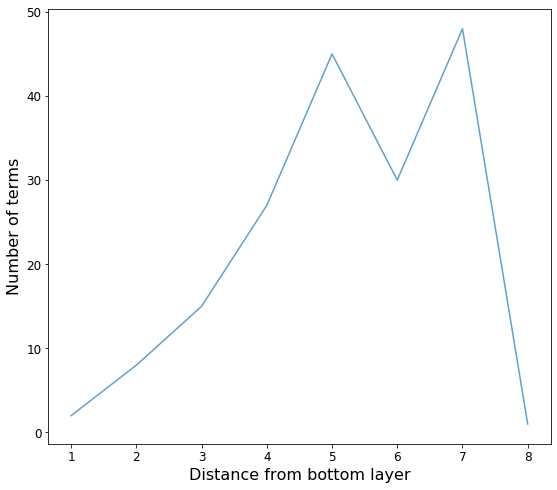

In [12]:
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111)
ax.plot(range(1, len(layers)+1), layers, alpha=0.7)
ax.grid(False)
ax.set_xlabel('Distance from bottom layer')
ax.set_ylabel('Number of terms')
plt.show()
fig.savefig('../plots/Reactome_small_neuron_count.png')

In [13]:
len(ontology['S'].unique())

156

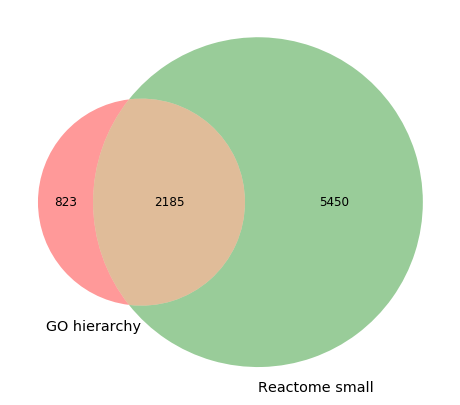

In [14]:
fig = plt.figure(figsize=(8,8))
venn2([genes_orig, genes], ['GO hierarchy', 'Reactome small'])
plt.show()
fig.savefig('../plots/Reactome_small_gene_overlap.png')